# 2) Downloading ERA5 data

Importing the necessary lybraries:


cfgrib is installed as:
conda install -c conda-forge cfgrib
xarray is installed as:
conda install -c conda-forge xarray dask netCDF4 bottleneck

In [1]:
import warnings
warnings.filterwarnings("ignore")
import sys;sys.path.append('../adcirc_swan')
import adcirc as adc;import regional as reg
from arctic import *
import getopt; import pathlib as pl
import pandas as pd;import numpy as np
import netCDF4 as nc4;import xarray as xr
import scipy.interpolate
import datetime;import json
from pyproj import Proj, transform,Transformer
import matplotlib.pyplot as plt;
import matplotlib as mpl;
import cartopy as cart;import shutil
import cartopy.crs as ccrs
import wrf;from scipy.io import loadmat
from wrf import PolarStereographic
from pyproj.crs import BoundCRS, Ellipsoid, GeographicCRS, ProjectedCRS
import geopandas as gpd;import shapely as shape
import boto3; import os;import urllib
import sys; from shapely import Polygon, Point, MultiPoint, LineString

Paste the API request and start downloading:

In [2]:
def force2owibasin(file:str,dx:float,dy:float,dt:np.array,ilon:int,ilat:int,\
                start:datetime,end:datetime,swlat:int,swlon:int,header:str,\
                lat1:float,lat2:float,lon1:float,lon2:float,lat=None,lon=None,data=None,\
                u=None,v=None,interval:int=1):


    with open(file,'w') as fin:
        fin.write(header)
        for t in np.arange(0,len(dt),interval):
            param ='iLat={:4d}iLong={:4d}DX={:6.4f}DY={:6.4f}SWLat={:8.5f}SWLon={:8.3f}DT={:12s}\n'.\
            format(ilat,ilon,dx,dy,swlat,swlon,str(dt[t].strftime('%Y%m%d%H%M')))#,width=8,prec=5)
            fin.write(param)
            data2 = []
            d1,d2 = [],[] 
            for y in range(0,lon.shape[0]):
                for x in range(0,lon.shape[1]):
                    if file == 'fort.224':
                        windx = u[t,y,x]
                        windy = v[t,y,x]
                        d1.append(' {:{width}.{prec}f}'.format(windx,width=9,prec=4))
                        d2.append(' {:{width}.{prec}f}'.format(windy,width=9,prec=4))
                    elif file == 'fort.223':
                        press = data[t,y,x]/100
                        data2.append(' {:{width}.{prec}f}'.format(press,width=9,prec=4))
                    elif file == 'fort.225':
                        sea = data[t,y,x]
                        if np.isnan(sea):
                            sea = -1.0
                        else:
                            sea =sea #* 100
                        data2.append(' {:{width}.{prec}f}'.format(sea,width=9,prec=4))
            i = 0
            if file == 'fort.224':
                for d in range(len(d1)):
                    if (i == 7) & (d+1!=len(d1)) :
                        fin.write(d1[d]+'\n')
                        i=0
                    elif d+1>=len(d1):
                        #print(d + 'made it here')
                        fin.write(d2[d]+'\n')
                        i = 0
                        for d in range(len(d2)):

                            if (i == 7) :
                                fin.write(d2[d]+'\n')
                                i=0
                            elif (d+1>=len(d2)):
                                fin.write(d2[d]+'\n')
                            else:
                                fin.write(d2[d])
                                i +=1
                    else:
                        fin.write(d1[d])
                        i +=1
            else:
                for d in range(len(data2)):
                    if (i == 7) : 
                        fin.write(data2[d]+'\n')
                        i=0
                    elif (d+1>=len(data2)):
                        fin.write(data2[d]+'\n')
                    else:
                        fin.write(data2[d])
                        i +=1

    return print('generated owi formatted forcings')

In [3]:
path = pl.Path('/Users/tmiesse/work/FHRL/arctic/model/ice_paper/storm2019/sea_ice/hycom')
files = list((path/'data').rglob('*.nc'))
files.sort()

In [7]:
files[17]

PosixPath('/Users/tmiesse/work/FHRL/arctic/model/ice_paper/storm2019/sea_ice/hycom/data/112_cice_inst.2019-10-18-00000.nc')

In [4]:
grib = xr.open_dataset(path / files[17], engine='netcdf4')
x = np.nan_to_num(grib['TLON'][:].data)
y= np.nan_to_num(grib['TLAT'][:].data)
x[x>180]=x[x>180]-360

In [5]:
grib

<xarray.Dataset>
Dimensions:   (time: 1, nj: 2520, ni: 1600)
Coordinates:
  * time      (time) datetime64[ns] 2019-10-18
    TLON      (nj, ni) float32 ...
    TLAT      (nj, ni) float32 ...
    ULON      (nj, ni) float32 ...
    ULAT      (nj, ni) float32 ...
Dimensions without coordinates: nj, ni
Data variables: (12/33)
    hi        (time, nj, ni) float32 ...
    hs        (time, nj, ni) float32 ...
    Tsfc      (time, nj, ni) float32 ...
    aice      (time, nj, ni) float32 ...
    uvel      (time, nj, ni) float32 ...
    vvel      (time, nj, ni) float32 ...
    ...        ...
    strcorx   (time, nj, ni) float32 ...
    strcory   (time, nj, ni) float32 ...
    strocnx   (time, nj, ni) float32 ...
    strocny   (time, nj, ni) float32 ...
    Tair      (time, nj, ni) float32 ...
    fswfac    (time, nj, ni) float32 ...
Attributes:
    title:        sea ice model output for CICE
    contents:     Diagnostic and Prognostic Variables
    source:       sea ice model: Community Ice Code (CICE)
    comment2:     File written on model date 20191018
    comment3:     seconds elapsed into model date:      0
    conventions:  CF-1.0
    history:      This dataset was created on 2020-05-15 at 08:10:10.5

In [9]:
x3 = np.zeros(x.shape)
for i in range(0,x.shape[0]):
    for j in range(0,x.shape[1]):
        if x[i,j]>0:
            x3[i,j] = x[i,j]-360
        else:
            x3[i,j] = x[i,j]

In [6]:
x,y = grib['xgrid'],grib['ygrid']
xgrid,ygrid = np.meshgrid(x,y)
inProj = Proj(init='epsg:3411')
outProj = Proj(init='epsg:4326')
x2,y2 = transform(inProj,outProj,xgrid,ygrid)

In [7]:
x3 = np.zeros(x2.shape)
for i in range(0,x2.shape[0]):
    for j in range(0,x2.shape[1]):
        if x2[i,j]>0:
            x3[i,j] = x2[i,j]-360
        else:
            x3[i,j] = x2[i,j]

In [10]:
xre = np.reshape(x3,x3.shape[0]*x3.shape[1])
yre = np.reshape(y,y.shape[0]*y.shape[1])
data = np.reshape(np.nan_to_num(grib['aice'][0,:,:].data),y.shape[0]*y.shape[1])
data[data>1]=0

In [11]:
cmap = mpl.cm.get_cmap('jet')
normalize = mpl.colors.Normalize(vmin=np.min(data), vmax=np.max(data))
colors = [cmap(normalize(d)) for d in data]

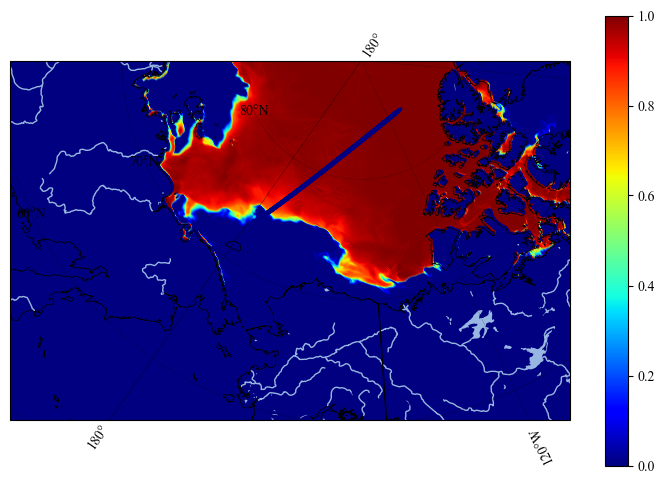

In [12]:
# map boundary ------------------------------------------------------------------------
lat1,lat2 = 60,90
lon1,lon2 = -220,-110

# -------------------------------------------------------------------------------------
plt.rcParams["font.family"] = "Times New Roman"
fig = plt.figure(figsize=(7,5))
proj = ccrs.NorthPolarStereo(central_longitude=-145)
ax = plt.axes([0,0,1.,1.],projection=proj)

fig.tight_layout(pad=0.75)
levels = np.arange(0,1,0.1)

# Initialize data for map
ax.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
ax.coastlines(resolution='10m',linewidth=0.5)
ax.add_feature(cart.feature.LAKES)
ax.add_feature(cart.feature.RIVERS, linestyle="-")
ax.add_feature(cart.feature.BORDERS.with_scale("50m"), linestyle="-")


ax.scatter(xre,yre,c=colors,s=5,cmap=cmap,transform = ccrs.PlateCarree())

cax, _ = mpl.colorbar.make_axes(ax,shrink=.9)
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=normalize)
gl = ax.gridlines(draw_labels=True, linewidth=0.3, color="black", alpha=0.5, linestyle="--")
# subplot adjustment -----------------------------------------------------------

#plt.savefig('/Users/tmiesse/work/FHRL/arctic/model/ice_paper/sea_ice/rasm-g/figures/october.png',dpi=480,bbox_inches = 'tight', pad_inches = 0.1)
plt.show(fig)

In [25]:
lat1,lat2 = 50,87
lon1,lon2 = -211, -80
grid_space = 0.18
xg = np.arange(lon1,lon2,grid_space)
yg = np.arange(lat1,lat2,grid_space)
xgrid,ygrid = np.meshgrid(xg,yg)
data = scipy.interpolate.griddata((lat,lon),temp,(ygrid,xgrid),method='nearest')
#data2 = np.reshape(np.nan_to_num(grib['aice'][0,:,:].data),y.shape[0]*y.shape[1])

ValueError: shape mismatch: objects cannot be broadcast to a single shape

In [21]:
#xre = np.reshape(x3,x3.shape[0]*x3.shape[1])
#yre = np.reshape(y2,y2.shape[0]*y2.shape[1])
daily = pd.date_range('20191001','20191231',freq='1D')
lat1,lat2 = 50,87
lon1,lon2 = -211, -80
grid_space = 0.09
xg = np.arange(lon1,lon2,grid_space)
yg = np.arange(lat1,lat2,grid_space)
xgrid,ygrid = np.meshgrid(xg,yg)
sice2 = np.zeros((len(files),xgrid.shape[0],xgrid.shape[1]))
count = 0
for day in daily:
    file = [s for s in files if pd.to_datetime(day.strftime('%Y-%m-%d-%H%M%S')) == pd.to_datetime(str(s.name).split('.')[1],format='%Y-%m-%d-%H%M%S')]
    grib = xr.open_dataset(path / file[0])
    sice = grib['aice'].data
    sice[sice>1]=0
    temp = np.reshape(sice[0,:,:],x3.shape[0]*x3.shape[1])
    data = scipy.interpolate.griddata((xre,yre),temp,(xgrid,ygrid),method='nearest')
    data[data>1]=1
    sice2[count,:,:] = data

    count+=1

In [20]:
file.name.split('.')[1]

'2019-10-13-00000'

In [25]:
#ts = [(t - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')  for t in time]
#ts2 = [datetime.datetime.utcfromtimestamp(t) for t in ts]
#ts2 = time
dx = 0.09#np.abs(lon[0]-lon[1])# 0.205 is cfsv2 wind increment
dy = 0.09#np.abs(lat[0]-lat[1])#
ilon = xgrid.shape[1]
ilat = xgrid.shape[0]
start = daily[0]
end = daily[-1]
swlat = lat1
swlon = lon1#+360
header = 'Oceanweather WIN/PRE Format                            {:12s}   {:12s}\n'.format(str(start.strftime('%Y%m%d%H')),str(end.strftime('%Y%m%d%H')))#     {}'
dt = daily#ts2[:478]
file = 'fort.225'

force2owibasin(file,dx,dy,dt,ilon,ilat,start,end,swlat,swlon,header,\
               lat1,lat2,lon1,lon2,lat=ygrid,lon=xgrid,data=sice2,interval=1)

generated owi formatted forcings


In [12]:
path = pl.Path('/Users/tmiesse/work/FHRL/arctic/ice_data/hiomas')
files = list((path  / 'grid').glob('*'))
grib = xr.open_dataset(path / files[1], engine='netcdf4')

In [13]:
lats,lons = grib['lat'],grib['lon']
files = list((path ).glob('*'))
data  =np.reshape(np.fromfile(files[20], dtype='f4', count = -1),(365,lons.shape[0],lons.shape[1]))

In [8]:
x[x>180]=x[x>180]-360

In [6]:
x3 = np.zeros(x.shape)
for i in range(0,x.shape[0]):
    for j in range(0,x.shape[1]):
        if x[i,j]>0:
            x3[i,j] = x[i,j]-360
        else:
            x3[i,j] = x[i,j]

In [14]:
daily = pd.date_range('20190101',periods=365,freq='1D')

In [10]:
#xg,yg = np.meshgrid(x,y)
xre = np.reshape(x3,x3.shape[0]*x3.shape[1])
yre = np.reshape(y,y.shape[0]*y.shape[1])
data = np.reshape(np.nan_to_num(grib['aice'][0,:,:].data),y.shape[0]*y.shape[1])

In [15]:
latr = np.reshape(lats.data,(lats.shape[0]*lats.shape[1]))
lonr = np.reshape(lons.data,(lons.shape[0]*lons.shape[1]))
lonr2= [lonr[i]-360 if lonr[i]>0 else lonr[i] for i in range(len(lonr))]
datar2=np.reshape(data[336,:,:].data,(lons.shape[0]*lons.shape[1]))

In [16]:
cmap = mpl.cm.get_cmap('jet')
normalize = mpl.colors.Normalize(vmin=np.min(datar2), vmax=np.max(datar2))
colors = [cmap(normalize(d)) for d in datar2]

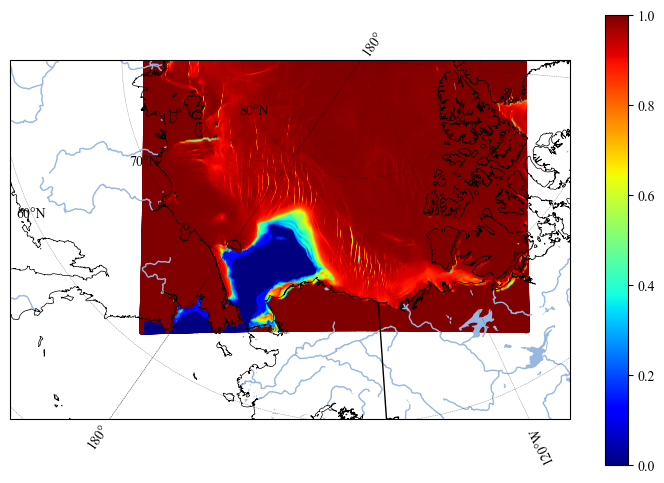

In [17]:
# map boundary ------------------------------------------------------------------------
lat1,lat2 = 60,90
lon1,lon2 = -220,-110

# -------------------------------------------------------------------------------------
plt.rcParams["font.family"] = "Times New Roman"
fig = plt.figure(figsize=(7,5))
proj = ccrs.NorthPolarStereo(central_longitude=-145)
ax = plt.axes([0,0,1.,1.],projection=proj)

fig.tight_layout(pad=0.75)
levels = np.arange(0,1,0.1)

# Initialize data for map
ax.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
ax.coastlines(resolution='10m',linewidth=0.5)
ax.add_feature(cart.feature.LAKES)
ax.add_feature(cart.feature.RIVERS, linestyle="-")
ax.add_feature(cart.feature.BORDERS.with_scale("50m"), linestyle="-")


ax.scatter(lonr2,latr,c=colors,s=5,cmap=cmap,transform = ccrs.PlateCarree())

cax, _ = mpl.colorbar.make_axes(ax,shrink=.9)
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=normalize)
gl = ax.gridlines(draw_labels=True, linewidth=0.3, color="black", alpha=0.5, linestyle="--")
# subplot adjustment -----------------------------------------------------------

plt.show(fig)

In [12]:
#xre = np.reshape(x3,x3.shape[0]*x3.shape[1])
#yre = np.reshape(y2,y2.shape[0]*y2.shape[1])
lat1,lat2 = 40,90
lon1,lon2 = -240, -80
grid_space = 0.09
xg = np.arange(lon1,lon2,grid_space)
yg = np.arange(lat1,lat2,grid_space)
xgrid,ygrid = np.meshgrid(xg,yg)
sice2 = np.zeros((len(files),xgrid.shape[0],xgrid.shape[1]))
count = 0
for day in daily:
    file = [s for s in files if pd.to_datetime(day.strftime('%Y-%m-%d-%H%M%S')) == pd.to_datetime(str(s.name).split('.')[1],format='%Y-%m-%d-%H%M%S')]
    grib = xr.open_dataset(path / file[0])
    sice = grib['aice'].data
    sice[sice>1]=0
    temp = np.reshape(sice[0,:,:],x3.shape[0]*x3.shape[1])
    data = scipy.interpolate.griddata((xre,yre),temp,(xgrid,ygrid),method='nearest')
    sice2[count,:,:] = data

    count+=1

In [14]:
#ts = [(t - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')  for t in time]
#ts2 = [datetime.datetime.utcfromtimestamp(t) for t in ts]
#ts2 = time
dx = 0.09#np.abs(lon[0]-lon[1])# 0.205 is cfsv2 wind increment
dy = 0.09#np.abs(lat[0]-lat[1])#
ilon = xgrid.shape[1]
ilat = xgrid.shape[0]
start = daily[0]
end = daily[-1]
swlat = lat1
swlon = lon1#+360
header = 'Oceanweather WIN/PRE Format                            {:12s}   {:12s}\n'.format(str(start.strftime('%Y%m%d%H')),str(end.strftime('%Y%m%d%H')))#     {}'
dt = daily#ts2[:478]
file = 'fort.225'

force2owibasin(file,dx,dy,dt,ilon,ilat,start,end,swlat,swlon,header,\
               lat1,lat2,lon1,lon2,lat=ygrid,lon=xgrid,data=sice2,interval=2)

generated owi formatted forcings


In [10]:
day.strftime('%Y-%m-%d-%H%M%S')

'2004-01-01-000000'

In [66]:
time = grib['time']
ts = [(t - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')  for t in time.data]
ts2 = [datetime.datetime.utcfromtimestamp(t) for t in ts]

UFuncTypeError: ufunc 'subtract' cannot use operands with types dtype('O') and dtype('<M8[s]')

In [17]:
#ts = [(t - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')  for t in time]
#ts2 = [datetime.datetime.utcfromtimestamp(t) for t in ts]
#ts2 = time
dx = 0.1#np.abs(lon[0]-lon[1])# 0.205 is cfsv2 wind increment
dy = 0.1#np.abs(lat[0]-lat[1])#
ilon = xgrid.shape[1]
ilat = xgrid.shape[0]
start = pd.to_datetime(daily[0])
end = pd.to_datetime(daily[-1])
swlat = lat1
swlon = lon1#+360
header = 'Oceanweather WIN/PRE Format                            {:12s}   {:12s}\n'.format(str(start.strftime('%Y%m%d%H')),str(end.strftime('%Y%m%d%H')))#     {}'
dt = daily
file = 'fort.225'

force2owibasin(file,dx,dy,dt,ilon,ilat,start,end,swlat,swlon,header,\
               lat1,lat2,lon1,lon2,lat=ygrid,lon=xgrid,data=sice2,interval=1)

generated owi formatted forcings


In [18]:
file = xr.open_dataset(files[9])
file2= xr.open_dataset(files2[2])
u = file['u10'][:]
v = file2['v10'][:]

In [19]:
time = file['time']
ts = [(t - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')  for t in time.data]
ts2 = [datetime.datetime.utcfromtimestamp(t) for t in ts]

In [23]:
ts2[478]

datetime.datetime(2004, 1, 20, 22, 0)

In [10]:
steps=0
start,end = pd.to_datetime('20191001'),pd.to_datetime('20200101')
for p in range(0,365):
    if (start<=daily[p]) & (daily[p]<end):
        steps+=1

In [11]:
lonr2 = [lonr[i]-360 if lonr[i]>0 else lonr[i] for i in range(len(lonr))]

lat1,lat2 = 50,90
lon1,lon2 = -211, -83
grid_space = 0.0175
xg = np.arange(lon1,lon2,grid_space)
yg = np.arange(lat1,lat2,grid_space)
xgrid,ygrid = np.meshgrid(xg,yg)
datat = np.zeros((steps,xgrid.shape[0],xgrid.shape[1]))
#datat[:] = np.nan

In [12]:
start,end = pd.to_datetime('20191001'),pd.to_datetime('20200101')
step=0
for p in range(300,301):
    if (start<=daily[p]) & (daily[p]<end):
        data2 = scipy.interpolate.griddata((lonr2,latr),np.reshape(data[p,:,:].data,len(lonr2)),(xgrid,ygrid),fill_value=np.nan,method='cubic')
        datat[step,:,:] = data2
        data2 = None
        step+=1


In [13]:
# map boundary ------------------------------------------------------------------------
lat1,lat2 = 60,90
lon1,lon2 = -220,-110
# -------------------------------------------------------------------------------------
plt.rcParams["font.family"] = "Times New Roman"
fig = plt.figure(figsize=(7,5))
fig.tight_layout(pad=0.75)
proj = ccrs.NorthPolarStereo(central_longitude=-145)
ax,cmap = plt.axes([0,0,1.,1.],projection=proj),mpl.cm.get_cmap('jet')
levels = np.arange(0,1.1,0.1)

# Initialize data for map
ax.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
ax.coastlines(resolution='10m',linewidth=0.5)
ax.add_feature(cart.feature.LAKES)
ax.add_feature(cart.feature.RIVERS, linestyle="-")
ax.add_feature(cart.feature.BORDERS.with_scale("50m"), linestyle="-")

ax.contourf(xgrid,ygrid,datat[0,:,:],cmap=cmap,levels=levels,transform = ccrs.PlateCarree())

gl = ax.gridlines(draw_labels=True, linewidth=0.3, color="black", alpha=0.5, linestyle="--")

plt.show(fig)

GEOSException: TopologyException: side location conflict at -109.90249999992776 66.327499999998409. This can occur if the input geometry is invalid.

Error in callback <function _draw_all_if_interactive at 0x122296c20> (for post_execute):


GEOSException: TopologyException: side location conflict at -109.90249999992776 66.327499999998409. This can occur if the input geometry is invalid.

GEOSException: TopologyException: side location conflict at -109.90249999992776 66.327499999998409. This can occur if the input geometry is invalid.

<Figure size 700x500 with 1 Axes>

In [24]:
xre = np.reshape(x3,x3.shape[0]*x3.shape[1])
yre = np.reshape(y2,y2.shape[0]*y2.shape[1])


lat1,lat2 = 60,90
lon1,lon2 = -180, -140
grid_space = 0.2
xg = np.arange(lon1,lon2,grid_space)
yg = np.arange(lat1,lat2,grid_space)
xgrid,ygrid = np.meshgrid(xg,yg)
u2 = np.zeros((u.shape[0],xgrid.shape[0],xgrid.shape[1]))
v2 = np.zeros((v.shape[0],xgrid.shape[0],xgrid.shape[1]))
start,end = pd.to_datetime('20191001'),pd.to_datetime('20200101')
for p in range(0,365):
    if
    temp = np.reshape(u.data[p,:,:],x2.shape[0]*x2.shape[1])
    data = scipy.interpolate.griddata((xre,yre),temp,(xgrid,ygrid),method='nearest')
    u2[p,:,:] = data
    temp2 = np.reshape(v.data[p,:,:],x2.shape[0]*x2.shape[1])
    data2 = scipy.interpolate.griddata((xre,yre),temp2,(xgrid,ygrid),method='nearest')
    v2[p,:,:] = data2

In [6]:
from shapely.geometry import Point,Polygon,LineString

In [7]:
countries = gpd.read_file('/Users/tmiesse/work/FHRL/arctic/gis/ne_10m_ocean/ne_10m_ocean.shp')

In [15]:
xs = np.reshape(x2,x2.shape[0]*x2.shape[1])
ys = np.reshape(y2,y2.shape[0]*y2.shape[1])
pts = [Point(xs[i],ys[i]) for i in range(0,len(xs))]

In [16]:
ids = []
c = 0
for pt in pts:
    if countries.geometry.contains(pt)[0]:
        ids.append(c)
    c+=1

KeyboardInterrupt: 

In [15]:
time = wrf_ds['time'][:]
count = 0
track = []
year = []
month = []

step = 0.01
xmin,xmax = 0,0
ymin,ymax = 0,0
oldpt = []
shpfile = {'year':[],'month':[],'geometry':[]}
for t in np.arange(0,len(time[:120]),6):
    psfc = np.reshape(wrf_ds['psfc'][t,:,:].data,x2.shape[0]*x2.shape[1])
            
            
    idx = np.where((psfc[ids]==np.min(psfc[ids])))[0]
    
    xmin,xmax = xs[idx]-step,xs[idx]+step
    ymin,ymax = ys[idx]-step,ys[idx]+step
    
    bbox = Polygon([[xmin,ymin],[xmax,ymin],[xmax,ymax],[xmin,ymax]])
    npt = pts[idx]
    if (npt not in track) & (bbox.contains(npt)):
        track.append(npt)
    elif (pd.to_datetime(time.data[t]).year not in year):
        year.append(pd.to_datetime(time.data[t]).year)
    elif pd.to_datetime(time.data[t]).month_name() not in month:
        month.append(pd.to_datetime(time.data[t]).month_name())

    if t>24:
        if npt in oldpt:
            shpfile['year'].append(year)
            shpfile['month'].append(month)
            shpfile['geometry'].append(track)
            track = []
            year = []
            month = []

    Progress(count,len(time[:]),title='Computing')
    count+=6


KeyboardInterrupt: 

In [11]:
file = pd.read_csv('/Users/tmiesse/work/FHRL/arctic/climate_data/era_interim/tracks/Post_processed_cyclones_MPI_ESM1_2_HR_historical.csv')

In [18]:
from datetime import date, timedelta
x,y = file['Lon'][:],file['Lat'][:]
start = date(1900,1,1) 
time = [start+timedelta(n)  for n in file['Time']]

ValueError: cannot convert float NaN to integer

In [12]:
days = pd.to_datetime(file['Time'][idx[1]])-pd.to_datetime(file['Time'][idx[-1]])#pd.Timedelta(hours=48)

NameError: name 'idx' is not defined

In [13]:
keys = file['Cyc_ID'].unique()
storm = {'track':[]}
step = 2
for k in range(0,len(keys)):
    idx = file.index[np.where(file['Cyc_ID']==keys[k])]
    tracks= {'id':[],'lat':[],'lon':[],'time':[]}
    count = 0
    for i in idx:
        if count<1:
            days = pd.to_datetime(file['Time'][idx[-1]])-pd.to_datetime(file['Time'][idx[1]])            
        if days.days>2:
            tracks['id'].append(file['Cyc_ID'][i])
            tracks['lat'].append(file['Lat'][i])
            if file['Lon'][i]>0:
                lons = file['Lon'][i]-360
            else:
                lons = file['Lon'][i]
            tracks['lon'].append(lons)
            tracks['time'].append(pd.to_datetime(file['Time'][i]))
        count+=1
    if len(tracks['id'])<2:
        pass
    else:
        storm['track'].append(tracks)

In [14]:
def noaa_data(begin,end,station,vdatum='NAVD',interval='6',
                       form='json',t_zone='GMT',unit='metric',product='water_level'):
    if product=='wind':
        api = f'https://api.tidesandcurrents.noaa.gov/api/prod/datagetter?begin_date={begin}&end_date={end}&station={station}'\
        f'&product={product}&time_zone={t_zone}&interval={interval}&units={unit}&application=DataAPI_Sample&format={form}'
    else:
        api = f'https://tidesandcurrents.noaa.gov/api/datagetter?begin_date={begin}&end_date={end}&station={station}'\
             f'&product={product}&application=NOS.COOPS.TAC.WL&datum={vdatum}&interval={interval}&time_zone={t_zone}&units={unit}&format={form}'
    data = requests.get(url=api).content.decode()
    return data


In [15]:
interval='h'
station=9497645
start = '20040101'
end   = '20040201'
noaa = json.loads(noaa_data(start,end,int(station),interval=interval,t_zone='LST',vdatum='MSL'))

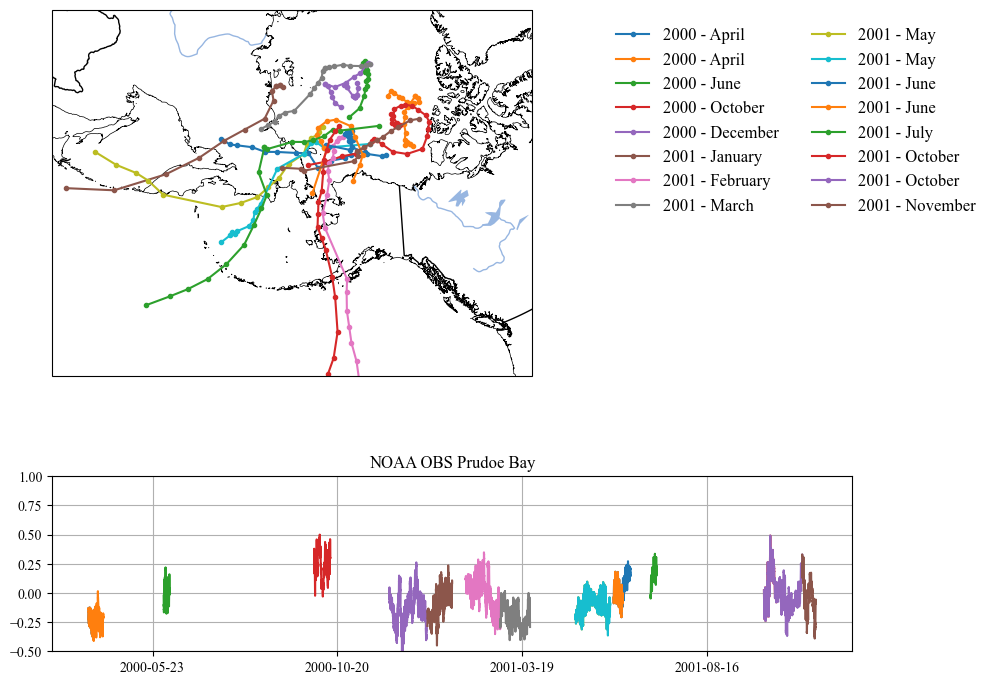

In [31]:

# map boundary ------------------------------------------------------------------------
lat1,lat2 = 45,90
lon1,lon2 = -240,-120

# -------------------------------------------------------------------------------------
plt.rcParams["font.family"] = "Times New Roman"
fig = plt.figure(figsize=(8,7))
proj = ccrs.NorthPolarStereo(central_longitude=-145)
ax1= plt.axes([0,0.28,0.6,0.75],projection=proj)
ax2 = plt.axes([0.,0.,1,0.25])
#ax[0].subplot_kw = dict(projection=proj)
cmap = mpl.cm.get_cmap('jet')
fig.tight_layout(pad=0.75)



ax1.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
ax1.coastlines(resolution='10m',linewidth=0.5)
ax1.add_feature(cart.feature.LAKES)
ax1.add_feature(cart.feature.RIVERS, linestyle="-")
ax1.add_feature(cart.feature.BORDERS.with_scale("50m"), linestyle="-")

start = 2000
end   = 2002
for t in storm['track']:
    noaa = None
    if start <= pd.to_datetime(t['time'][1]).year < end:
        xmin,xmax = -220,-120
        ymin,ymax = 0,90
        bbox1 = Polygon([[xmin,ymin],[xmax,ymin],[xmax,ymax],[xmin,ymax]])
        if ((bbox1.contains(Point(t['lon'][1],t['lat'][1])))&(bbox1.contains(Point(t['lon'][-1],t['lat'][-1])))):
            start2=str(pd.to_datetime(t['time'][1]).year)+str(pd.to_datetime(t['time'][1]).strftime('%m'))+'01'
            end2  =pd.to_datetime(t['time'][-1])
            noaa = json.loads(noaa_data(start2,end2,int(station),interval=interval,t_zone='LST',vdatum='MSL'))            
            if len(noaa)>1:
            
                ax1.plot(t['lon'],t['lat'],'.-',transform = ccrs.PlateCarree(),\
                        label=f"{pd.to_datetime(t['time'][1]).year} - {pd.to_datetime(t['time'][1]).month_name()}")

                ax2.plot(pd.to_datetime([noaa['data'][i]['t'] for i in range(len(noaa['data']))]),
                        [float(noaa['data'][i]['v']) for i in range(len(noaa['data']))],label='Station 1')
ax1.legend(loc='lower center', bbox_to_anchor=(1.55, 0.4),ncol=2,frameon=False,fontsize=12)
# subplot adjustment -----------------------------------------------------------
#plt.setp(ax[1].xaxis.get_label(), visible=True, text='Dates')
#plt.setp(ax[1].get_xticklabels(), visible=True, rotation=30, ha='right')
#ax2.set_xlim([pd.to_datetime('2004-01-01'),pd.to_datetime('2004-04-20')])
ax2.set_title('NOAA OBS Prudoe Bay')
ax2.set_ylim([-0.5,1])
ax2.xaxis.set_major_locator(plt.MaxNLocator(6)),ax2.yaxis.set_major_locator(plt.MaxNLocator(6))
ax2.grid(True)

#plt.savefig('/Users/tmiesse/work/FHRL/arctic/climate_data/era_interim/tracks/jan2004.png',dpi=450,bbox_inches = 'tight', pad_inches = 0.1)
plt.show(fig)

In [105]:
start2

'20040301'

In [227]:

mpts = []
years = []
months = []
name = []
for t in storm['track']:    
    if pd.to_datetime(t['time'][1]).year > 1979:
        xmin,xmax = -240,-120
        ymin,ymax = 20,88
        bbox1 = Polygon([[xmin,ymin],[xmax,ymin],[xmax,ymax],[xmin,ymax]])
        if ((bbox1.contains(Point(t['lon'][1],t['lat'][1])))&(bbox1.contains(Point(t['lon'][-1],t['lat'][-1])))):
            name.append(t['id'][1])
            years.append(t['time'][1].year)
            months.append(pd.to_datetime(t['time'][1]).month_name())
            pts = [Point(t['lon'][i],t['lat'][i]) for i in range(1,len(t['lat']))]
            mpts.append(LineString(pts))

            


In [228]:
shapefile = gpd.GeoDataFrame({'Cyclone':name,'Year':years,'Month':months, 'geometry':mpts},geometry='geometry',crs='epsg:4326')

In [229]:
shapefile.to_file('/Users/tmiesse/work/FHRL/arctic/climate_data/era_interim/tracks/mpi_esm1.shp')

In [217]:
count

1706